In [209]:
import torch
import matplotlib.pyplot
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

In [210]:
ds = torchvision.datasets.CIFAR10('./', download=True, transform=torchvision.transforms.ToTensor())
x, y = ds[1]
x.shape

Files already downloaded and verified


torch.Size([3, 32, 32])

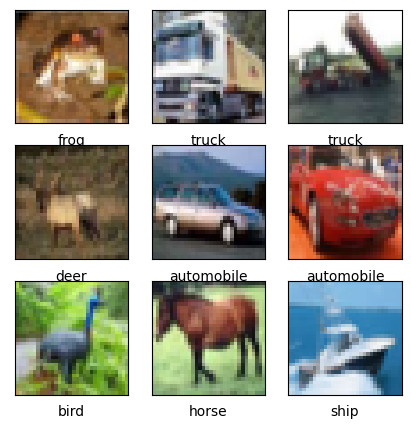

In [316]:
# show a 9x9 grid of images example from dataset ds, with text labels
plt.figure(figsize=(5,5))
for i in range(3*3):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(ds[i][0].permute(1, 2, 0))
    plt.xlabel(ds.classes[ds[i][1]])

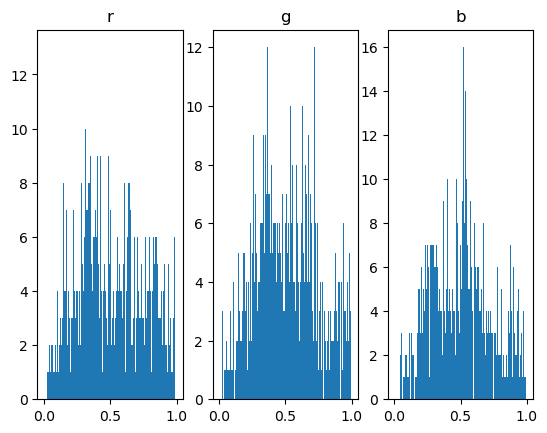

In [212]:
x, y = ds[1]
for c in range(3):
    xc = x[c]
    plt.subplot(1, 3, c+1)
    plt.hist(xc.ravel(), bins=256, range=(0.0, 1.0));
    plt.title(["r", "g", "b"][c])

In [213]:
x[0].min(), x[0].max()

(tensor(0.0196), tensor(0.9961))

In [214]:
# y: (B)  yh: (B)

y = torch.tensor([1, 2, 3, 4])
yh = torch.tensor([1, 0, 0, 0])

def accuracy(y, yh):
    return (y == yh).float().mean()

accuracy(y, yh)

tensor(0.2500)

In [215]:
train_ds, valid_ds = torch.utils.data.random_split(ds, [0.9, 0.1], generator=torch.Generator())
len(train_ds), len(valid_ds)

(45000, 5000)

In [153]:
@torch.no_grad()
def eval_split(split, model, samples=None):
    batch_size = 256
    ds = train_ds if split == "train" else valid_ds
    dl = torch.utils.data.DataLoader(ds, batch_size=256, shuffle=True, generator=torch.Generator())
    lossi = []
    acci = []

    for i, (xb, yb) in enumerate(dl):
        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        lossi.append(loss.item())
        
        prob = F.softmax(logits, dim=1) # (B, 10)
        yh = torch.argmax(prob, dim=1) # (B)
        acc = accuracy(yh, yb)
        acci.append(acc.item())

        if samples and i * batch_size > samples:
            break

    return torch.tensor(lossi).mean(), torch.tensor(acci).mean()

In [374]:
class MLP(nn.Module):

    def __init__(self) -> None:
        super().__init__()


        self.linear1 = nn.Linear(32*32*3, 1024)
        nn.init.kaiming_normal_(self.linear1.weight, nonlinearity='relu')

        self.linear2 = nn.Linear(1024, 512)
        nn.init.kaiming_normal_(self.linear2.weight, nonlinearity='relu')

        self.linear3 = nn.Linear(512, 256)
        nn.init.kaiming_normal_(self.linear3.weight, nonlinearity='relu')

        self.linear4 = nn.Linear(256, 10)
        self.linear4.bias = nn.Parameter(torch.zeros_like(self.linear4.bias)))
        self.h = [0] * 5

    
    # x: (B, 3, 32, 32)
    # y: (B, 10)
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        self.h[0] = x

        x = self.linear1(x).relu()
        self.h[1] = x

        x = self.linear2(x).relu()
        self.h[2] = x

        x = self.linear3(x).relu()
        self.h[3] = x

        x = self.linear4(x)
        self.h[4] = x

        return x

model = MLP()
sum([p.numel() for p in model.parameters()])

3805450

In [ ]:
dl = torch.utils.data.DataLoader(train_ds, batch_size=32)
metrics = []
lr = 0.001
epoch = 5
i = 0
n = len(dl) * epoch

optimizer = torch.optim.SGD(model.parameters(), 0.005)

for _ in range(epoch):
    for xb, yb in dl:
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)

        loss.backward()
        optimizer.step()
        
        # for p in params:
        #     p -= lr * p.grad
        #     update = lr * p.grad
        #     # param_scale = torch.linalg.norm(p.ravel())
        #     # update_scale = torch.linalg.norm(update.ravel())
        #     # print(update_scale / param_scale)

        i += 1
        if i % 100 == 0:
            tr_loss, tr_acc = eval_split("train", model, samples=1000)
            va_loss, va_acc = eval_split("valid", model, samples=1000)
            print(f"{i/n:.2f}: {tr_loss:.4f} {tr_acc:.4f} {va_loss:.4f} {va_acc:.4f}")
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))

0.01: 2.1813 0.2125 2.1903 0.2203
0.03: 2.0993 0.2336 2.1137 0.2398
0.04: 2.0391 0.2594 2.0594 0.2648
0.06: 1.9816 0.2937 1.9932 0.2898
0.07: 1.9636 0.2937 1.9643 0.3023
0.09: 1.9139 0.3359 1.9267 0.3273
0.10: 1.9056 0.3078 1.9217 0.3078
0.11: 1.8857 0.3094 1.8921 0.3141
0.13: 1.8524 0.3562 1.8587 0.3586
0.14: 1.8595 0.3398 1.8663 0.3352
0.16: 1.8452 0.3547 1.8513 0.3555
0.17: 1.8098 0.3586 1.8185 0.3789
0.18: 1.8409 0.3477 1.8410 0.3492
0.20: 1.8041 0.3680 1.8043 0.3703
0.21: 1.7892 0.3828 1.7981 0.3938
0.23: 1.7914 0.3531 1.7945 0.3594
0.24: 1.7814 0.3797 1.7869 0.3812
0.26: 1.7720 0.3812 1.7701 0.3836
0.27: 1.7619 0.3812 1.7592 0.3828
0.28: 1.7465 0.4055 1.7578 0.3969
0.30: 1.7313 0.3977 1.7410 0.3875
0.31: 1.7221 0.4070 1.7329 0.3883
0.33: 1.7413 0.3930 1.7392 0.3773
0.34: 1.7240 0.4062 1.7328 0.3969
0.36: 1.7090 0.3938 1.7255 0.4055
0.37: 1.6911 0.3961 1.7038 0.4109
0.38: 1.7061 0.4125 1.7151 0.3992
0.40: 1.6903 0.4047 1.7062 0.3984
0.41: 1.6818 0.4102 1.7011 0.4133
0.43: 1.6770 0

## Experiement

In [352]:
a = nn.Linear(32*32*3, 1024)
nn.init.kaiming_normal_(a.weight, nonlinearity='relu')
a.weight.mean(), a.weight.std(), a.bias.mean(), a.bias.std()

(tensor(7.7353e-06, grad_fn=<MeanBackward0>),
 tensor(0.0255, grad_fn=<StdBackward0>),
 tensor(0.0002, grad_fn=<MeanBackward0>),
 tensor(0.0100, grad_fn=<StdBackward0>))

In [349]:
torch.tensor(2).sqrt() / torch.tensor(32*32*3).sqrt()

tensor(0.0255)

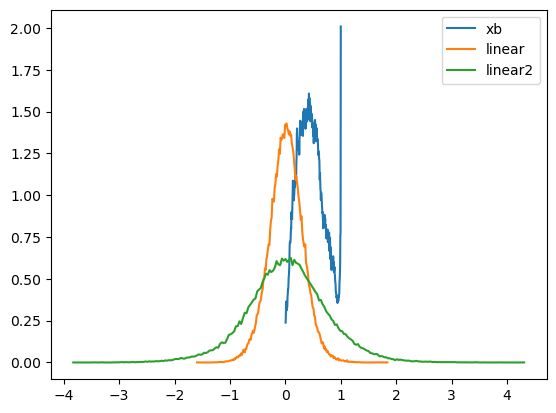

In [331]:
dl = torch.utils.data.DataLoader(train_ds, batch_size=128)
xb, yb = next(iter(dl))


xb = xb.view(-1, 32*32*3)
val, axis = xb.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="xb")

linear1 = nn.Linear(32*32*3, 1024)
linear1.requires_grad_(False)
a = linear1(xb)
val, axis = a.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="linear")


linear2 = nn.Linear(32*32*3, 1024)
linear2.requires_grad_(False)
nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
a = linear2(xb)
val, axis = a.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="linear2")

plt.legend()

## Sanity Check

In [379]:
dl = torch.utils.data.DataLoader(train_ds, batch_size=512)

for p in model.parameters():
    p.grad = None

xb, yb = next(iter(dl))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("loss:", loss.item())
print("chance:", -torch.tensor(1/10).log().item())

loss: 2.3740603923797607
chance: 2.3025851249694824


layer 0: mean +0.47, std 0.24, zero: 0.09%
layer 1: mean +0.28, std 0.42, zero: 49.35%


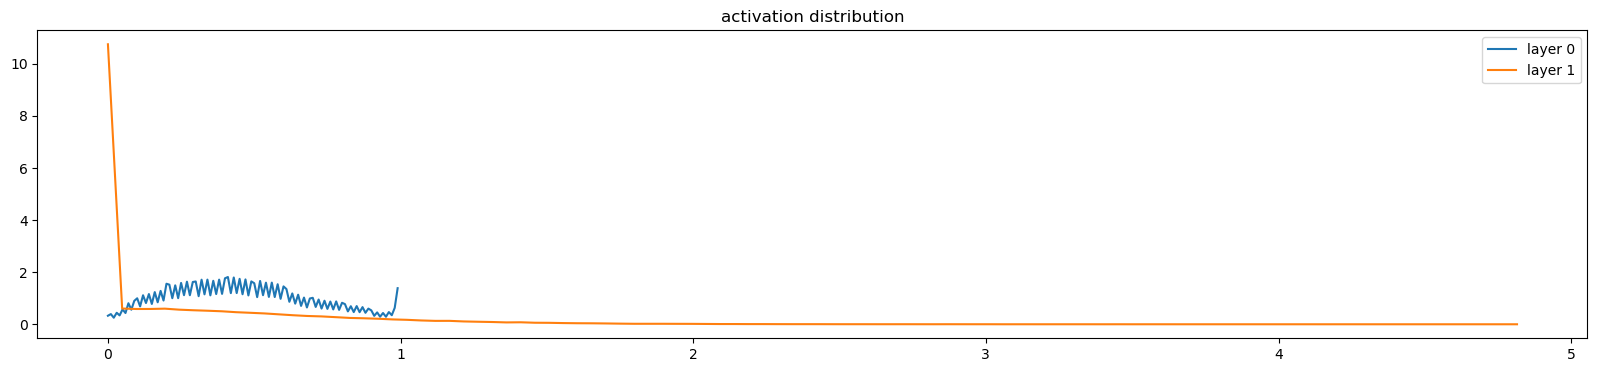

In [347]:
plt.figure(figsize=(20, 4))
legends = []
for i, t in enumerate(model.h[0:2]):
    print('layer %d: mean %+.2f, std %.2f, zero: %.2f%%' % (i, t.mean(), t.std(), (t.abs() == 0).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('activation distribution');

layer 0: mean +0.00, std 0.00, zero: 24.21%
layer 1: mean +0.00, std 0.00, zero: 47.35%
layer 2: mean -0.00, std 0.04, zero: 20.06%


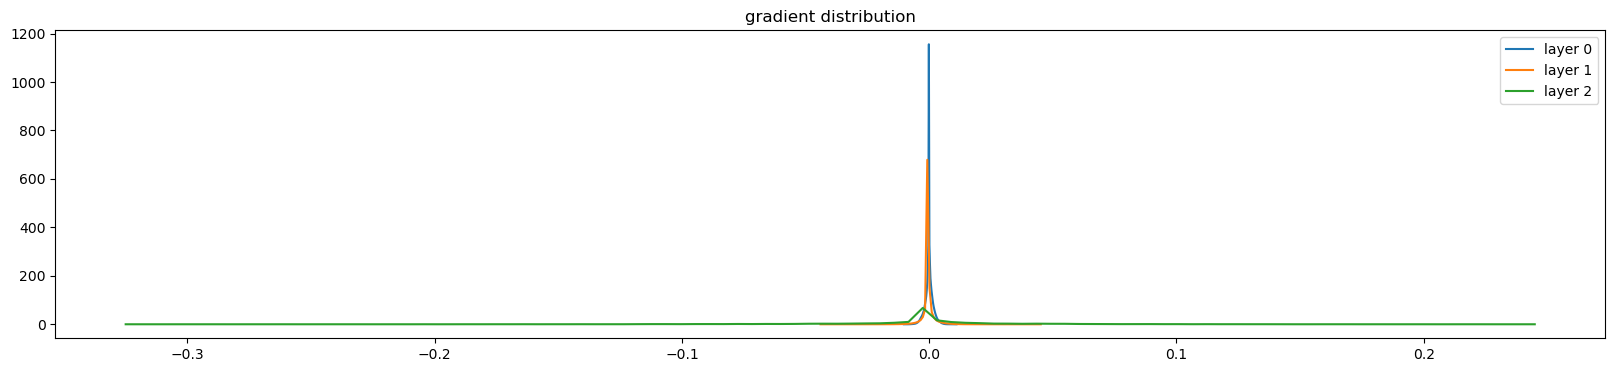

In [243]:
plt.figure(figsize=(20, 4))
legends = []
layers = [model.linear1, model.linear2, model.linear3]

for i, l in enumerate(layers):
    t = l.weight.grad
    print('layer %d: mean %+.2f, std %.2f, zero: %.2f%%' % (i, t.mean(), t.std(), (t.abs() < 0.0001).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('gradient distribution');

In [164]:
print("train", eval_split("train", model, samples=1000))
print("valid", eval_split("valid", model, samples=1000))
print("chance", -torch.tensor(1/10).log())

train (tensor(2.3039), tensor(0.0609))
valid (tensor(2.3054), tensor(0.0594))
chance tensor(2.3026)


## Training

In [306]:
model = MLP()

In [371]:
dl = torch.utils.data.DataLoader(train_ds, batch_size=32)
metrics = []
lr = 0.001
epoch = 5
i = 0
n = len(dl) * epoch

optimizer = torch.optim.SGD(model.parameters(), 0.005)

for _ in range(epoch):
    for xb, yb in dl:
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)

        loss.backward()
        optimizer.step()
        
        # for p in params:
        #     p -= lr * p.grad
        #     update = lr * p.grad
        #     # param_scale = torch.linalg.norm(p.ravel())
        #     # update_scale = torch.linalg.norm(update.ravel())
        #     # print(update_scale / param_scale)

        i += 1
        if i % 100 == 0:
            tr_loss, tr_acc = eval_split("train", model, samples=1000)
            va_loss, va_acc = eval_split("valid", model, samples=1000)
            print(f"{i/n:.2f}: {tr_loss:.4f} {tr_acc:.4f} {va_loss:.4f} {va_acc:.4f}")
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))

0.01: 2.1813 0.2125 2.1903 0.2203
0.03: 2.0993 0.2336 2.1137 0.2398
0.04: 2.0391 0.2594 2.0594 0.2648
0.06: 1.9816 0.2937 1.9932 0.2898
0.07: 1.9636 0.2937 1.9643 0.3023
0.09: 1.9139 0.3359 1.9267 0.3273
0.10: 1.9056 0.3078 1.9217 0.3078
0.11: 1.8857 0.3094 1.8921 0.3141
0.13: 1.8524 0.3562 1.8587 0.3586
0.14: 1.8595 0.3398 1.8663 0.3352
0.16: 1.8452 0.3547 1.8513 0.3555
0.17: 1.8098 0.3586 1.8185 0.3789
0.18: 1.8409 0.3477 1.8410 0.3492
0.20: 1.8041 0.3680 1.8043 0.3703
0.21: 1.7892 0.3828 1.7981 0.3938
0.23: 1.7914 0.3531 1.7945 0.3594
0.24: 1.7814 0.3797 1.7869 0.3812
0.26: 1.7720 0.3812 1.7701 0.3836
0.27: 1.7619 0.3812 1.7592 0.3828
0.28: 1.7465 0.4055 1.7578 0.3969
0.30: 1.7313 0.3977 1.7410 0.3875
0.31: 1.7221 0.4070 1.7329 0.3883
0.33: 1.7413 0.3930 1.7392 0.3773
0.34: 1.7240 0.4062 1.7328 0.3969
0.36: 1.7090 0.3938 1.7255 0.4055
0.37: 1.6911 0.3961 1.7038 0.4109
0.38: 1.7061 0.4125 1.7151 0.3992
0.40: 1.6903 0.4047 1.7062 0.3984
0.41: 1.6818 0.4102 1.7011 0.4133
0.43: 1.6770 0

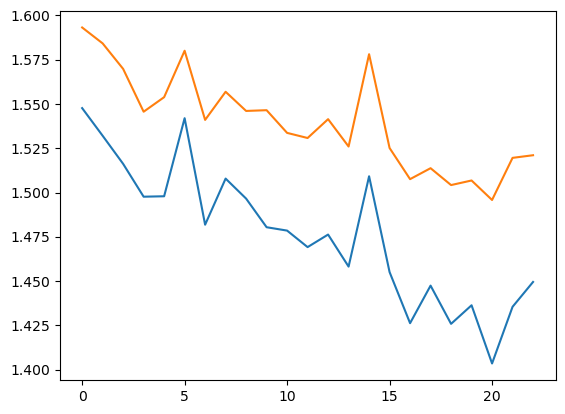

In [319]:
# plot loss and accuracy, one on left and another on the right
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)
plt.plot(tr_loss, label="tr_loss")
plt.plot(va_loss, label="va_loss")

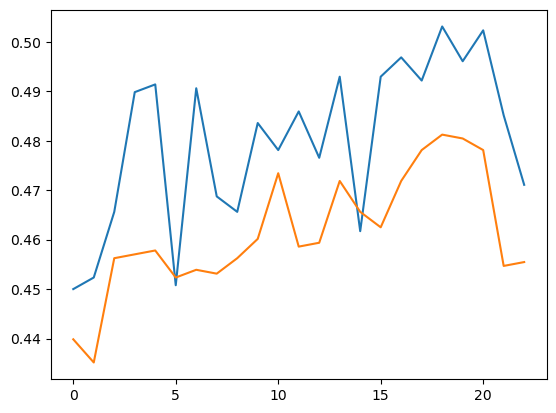

In [320]:
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)
plt.plot(tr_acc, label="tr_acc")
plt.plot(va_acc, label="va_acc")

In [369]:
@torch.no_grad()
def predict(x):
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    return yh

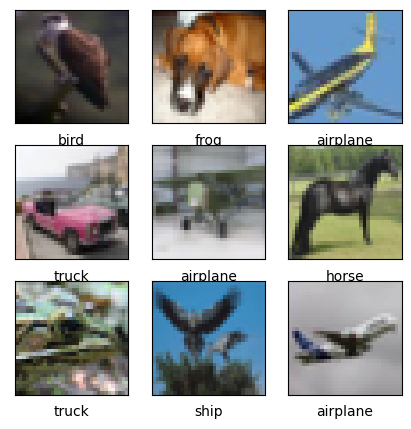

In [373]:
dl = torch.utils.data.DataLoader(valid_ds, batch_size=9, shuffle=True)
x, y = next(iter(dl))
yh = predict(x)

plt.figure(figsize=(5,5))
for i in range(3*3):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i].permute(1, 2, 0))
    plt.xlabel(ds.classes[yh[i]])